# Gesture LSTM vs 1$ recognizer

In this notebook we create multiple LSTMs with different parametercounts to recognize gestures and test its on our own dataset and the wobbrock gesture dataset.
We also compare the LSTM to the 1$ recognizer and then perform some significance tests. The notebook finishes by discussing pros and contras to both approaches to gesture recognizers.

In [ ]:
import xml.etree.ElementTree as ET
from pathlib import Path

import random
import time
import sys
import types

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks

RANDOM_SEED_NUMBER = 42
random.seed(RANDOM_SEED_NUMBER)
np.random.seed(RANDOM_SEED_NUMBER)
tf.random.set_seed(RANDOM_SEED_NUMBER)

BASE_DATA_FOLDER_PATH = Path("datasets")
DATASET_DIRECTORY_LOOKUP_TABLE = {
        "mid_air" : BASE_DATA_FOLDER_PATH / "own_recorded_gestures",
        "wobbrock": BASE_DATA_FOLDER_PATH / "wobbrock_slow_0"
}

NUMBER_OF_POINTS_FOR_EACH_GESTURE = 128

## HELPERS TO PARSE DATA FROM THE XML DATASETS AND MAKE IT USEABLE FOR LSTM

In [ ]:
def parsePointsFromSingleXmlFile(xml_file_path : Path) -> np.ndarray:
    list_of_points = []
    root_element_of_file = ET.parse(xml_file_path).getroot()
    for point_element in root_element_of_file.findall(".//Point"):
        x_value = float(point_element.attrib["X"])
        y_value = float(point_element.attrib["Y"])
        list_of_points.append([x_value, y_value])
    list_of_points_array = np.asarray(list_of_points, dtype = np.float32)
    return list_of_points_array

def resamplePointsToFixedSize(original_points_array : np.ndarray,
                              desired_number_of_points = NUMBER_OF_POINTS_FOR_EACH_GESTURE) -> np.ndarray:

    if len(original_points_array)==0:
        return np.zeros((desired_number_of_points, 2), dtype = np.float32)

    distance_between_every_pair = np.sqrt(((original_points_array[1:] - original_points_array[:-1])**2).sum(1))
    total_path_distance = distance_between_every_pair.sum()

    if total_path_distance==0:
        first_point_repeated = np.repeat(original_points_array[:1], desired_number_of_points, axis = 0)
        return first_point_repeated

    interval_length= total_path_distance / (desired_number_of_points - 1)
    distance_along_current_segment = 0.0
    new_points_list= [original_points_array[0]]
    index_inside_loop= 1

    while index_inside_loop < len(original_points_array):
        distance_this_step = np.linalg.norm(original_points_array[index_inside_loop] - original_points_array[index_inside_loop - 1])

        if distance_along_current_segment + distance_this_step >= interval_length:
            interpolation_ratio= (interval_length - distance_along_current_segment) / distance_this_step
            interpolation_point= original_points_array[index_inside_loop - 1] + interpolation_ratio * (original_points_array[index_inside_loop] - original_points_array[index_inside_loop - 1])
            new_points_list.append(interpolation_point)
            original_points_array  = np.insert(original_points_array, index_inside_loop, interpolation_point, axis = 0)
            distance_along_current_segment = 0.0
            index_inside_loop += 1
        else:
            distance_along_current_segment += distance_this_step
            index_inside_loop += 1

    while len(new_points_list) < desired_number_of_points:
        new_points_list.append(original_points_array[-1])

    resampled_array = np.vstack(new_points_list[:desired_number_of_points]).astype(np.float32)
    return resampled_array

def normalisePointCloud(points_array : np.ndarray) -> np.ndarray:
    centred_points = points_array - points_array.mean(0)
    max_abs_value  = np.abs(centred_points).max()
    if max_abs_value>0:
        centred_points = centred_points / max_abs_value
    return centred_points


In [ ]:
def loadWholeDatasetByKey(dataset_key_string : str) -> pd.DataFrame:
    folder_for_this_dataset = DATASET_DIRECTORY_LOOKUP_TABLE[dataset_key_string]
    list_of_rows = []

    for xml_file_path in sorted(folder_for_this_dataset.glob("*.xml")):
        gesture_label_raw  = xml_file_path.stem.rstrip("0123456789")
        gesture_label_tidy = gesture_label_raw.lower()

        single_row_dictionary = {
            "points" : parsePointsFromSingleXmlFile(xml_file_path),
            "gesture": gesture_label_tidy,
            "dataset": dataset_key_string,
            "file"   : xml_file_path.name
        }
        list_of_rows.append(single_row_dictionary)

    data_frame_for_one_dataset = pd.DataFrame(list_of_rows)
    return data_frame_for_one_dataset

## CREATE DATASETS FOR MID-AIR AND WOBBROCK

In [49]:
dataframe_mid_air_gestures   = loadWholeDatasetByKey("mid_air")
dataframe_wobbrock_gestures  = loadWholeDatasetByKey("wobbrock")

dataframe_all_gesture_samples = pd.concat(
        [dataframe_mid_air_gestures, dataframe_wobbrock_gestures],
        ignore_index = True
)

print("Loaded", len(dataframe_all_gesture_samples), "total samples")

dataframe_all_gesture_samples.head()


Loaded 100 total samples


,points,gesture,dataset,file
0,"[[553.0, 326.0], [551.0, 326.0], [550.0, 327.0...",check,mid_air,check01.xml
1,"[[360.0, 466.0], [356.0, 465.0], [348.0, 452.0...",check,mid_air,check02.xml
2,"[[574.0, 613.0], [570.0, 611.0], [569.0, 607.0...",check,mid_air,check03.xml
3,"[[694.0, 594.0], [693.0, 591.0], [692.0, 589.0...",check,mid_air,check04.xml
4,"[[381.0, 643.0], [379.0, 649.0], [379.0, 654.0...",check,mid_air,check05.xml


In [50]:
dataframe_all_gesture_samples["normalised_resampled_points"] = dataframe_all_gesture_samples.points.apply(
        lambda current_array : normalisePointCloud(
            resamplePointsToFixedSize(current_array)
        )
)


## SPLIT INTO TEST TRAIN

In [ ]:
dataframe_only_wobbrock = dataframe_all_gesture_samples[dataframe_all_gesture_samples.dataset=="wobbrock"].reset_index(drop = True)

dataframe_only_mid_air = dataframe_all_gesture_samples[dataframe_all_gesture_samples.dataset=="mid_air"].reset_index(drop = True)

features_wobbrock= np.stack(dataframe_only_wobbrock["normalised_resampled_points"].to_numpy())
labels_wobbrock= dataframe_only_wobbrock["gesture"].to_numpy()

features_mid_air= np.stack(dataframe_only_mid_air["normalised_resampled_points"].to_numpy())
labels_mid_air= dataframe_only_mid_air["gesture"].to_numpy()

X_wob_train, X_wob_test, y_wob_train, y_wob_test = train_test_split(
        features_wobbrock,
        labels_wobbrock,
        test_size= 0.20,
        stratify= labels_wobbrock,
        random_state= RANDOM_SEED_NUMBER
)

X_mid_train, X_mid_test, y_mid_train, y_mid_test = train_test_split(
        features_mid_air,
        labels_mid_air,
        test_size= 0.20,
        stratify= labels_mid_air,
        random_state= RANDOM_SEED_NUMBER
)

label_encoder_for_gestures = LabelEncoder().fit(dataframe_all_gesture_samples.gesture)

y_wob_train_one_hot = tf.keras.utils.to_categorical(label_encoder_for_gestures.transform(y_wob_train))
y_mid_train_one_hot = tf.keras.utils.to_categorical(label_encoder_for_gestures.transform(y_mid_train))


In [52]:
def makeSimpleLstmModel(number_of_hidden_units        = 64,
                        how_many_lstm_layers          = 2,
                        dropout_fraction_between_layers = 0.2):

    sequential_model = models.Sequential(
            name = f"Lstm_h{number_of_hidden_units}_L{how_many_lstm_layers}"
    )

    sequential_model.add(
            layers.Input(shape = (NUMBER_OF_POINTS_FOR_EACH_GESTURE, 2))
    )

    for _ in range(how_many_lstm_layers - 1):
        sequential_model.add(
                layers.LSTM(number_of_hidden_units, return_sequences = True)
        )
        if dropout_fraction_between_layers:
            sequential_model.add(layers.Dropout(dropout_fraction_between_layers))

    sequential_model.add(layers.LSTM(number_of_hidden_units))

    if dropout_fraction_between_layers:
        sequential_model.add(layers.Dropout(dropout_fraction_between_layers))

    sequential_model.add(
            layers.Dense(len(label_encoder_for_gestures.classes_), activation = "softmax")
    )

    sequential_model.compile(
            optimizer = "adam",
            loss      = "categorical_crossentropy",
            metrics   = ["accuracy"]
    )

    return sequential_model


## PARAMETER EXPERIMENT

This is a set up for multiple configurations for the LSTM. This makes training take up to an hour, so delete some if you want it to run faster.

In [ ]:
LSTM_SETTINGS_LIST = [
    dict(number_of_hidden_units = 256, how_many_lstm_layers =  32, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  32, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  24, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  20, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  16, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  14, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  12, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  10, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  8, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  4, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units = 128, how_many_lstm_layers =  3, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units =  64, how_many_lstm_layers =  3, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units =  32, how_many_lstm_layers =  2, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units =  16, how_many_lstm_layers =  10, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units =  16, how_many_lstm_layers =  2, dropout_fraction_between_layers = 0),
    dict(number_of_hidden_units =  16, how_many_lstm_layers =  1, dropout_fraction_between_layers = 0),
]


In [54]:
def trainSeveralModelsOnOneDataset(feature_tensor      : np.ndarray,
                                   label_tensor_onehot : np.ndarray,
                                   name_prefix         : str):

    list_of_trained_models = []

    for single_configuration_dictionary in LSTM_SETTINGS_LIST:
        model_to_train = makeSimpleLstmModel(**single_configuration_dictionary)

        early_stop_cb = callbacks.EarlyStopping(
                monitor              = "val_accuracy",
                patience             = 6,
                restore_best_weights = True,
                verbose              = 0
        )

        print("training", name_prefix, ":", model_to_train.name)

        model_to_train.fit(
                feature_tensor,
                label_tensor_onehot,
                epochs            = 80,
                batch_size        = 32,
                validation_split  = 0.15,
                verbose           = 0,
                callbacks         = [early_stop_cb]
        )

        list_of_trained_models.append(model_to_train)

    return list_of_trained_models


trained_models_for_wobbrock = trainSeveralModelsOnOneDataset(X_wob_train, y_wob_train_one_hot, "wobbrock")
trained_models_for_mid_air  = trainSeveralModelsOnOneDataset(X_mid_train, y_mid_train_one_hot, "mid-air")


training wobbrock : Lstm_h256_L32
training wobbrock : Lstm_h128_L32
training wobbrock : Lstm_h128_L24
training wobbrock : Lstm_h128_L20
training wobbrock : Lstm_h128_L16
training wobbrock : Lstm_h128_L14
training wobbrock : Lstm_h128_L12
training wobbrock : Lstm_h128_L10
training wobbrock : Lstm_h128_L8
training wobbrock : Lstm_h128_L4
training wobbrock : Lstm_h128_L3
training wobbrock : Lstm_h64_L3
training wobbrock : Lstm_h32_L2
training wobbrock : Lstm_h16_L10
training wobbrock : Lstm_h16_L2
training wobbrock : Lstm_h16_L1
training mid-air : Lstm_h256_L32
training mid-air : Lstm_h128_L32
training mid-air : Lstm_h128_L24
training mid-air : Lstm_h128_L20
training mid-air : Lstm_h128_L16
training mid-air : Lstm_h128_L14
training mid-air : Lstm_h128_L12
training mid-air : Lstm_h128_L10
training mid-air : Lstm_h128_L8
training mid-air : Lstm_h128_L4
training mid-air : Lstm_h128_L3
training mid-air : Lstm_h64_L3
training mid-air : Lstm_h32_L2
training mid-air : Lstm_h16_L10
training mid-a

## ADD OUR 1$ RECOGNIZER TO COMPARE OUR LSTM TO

In [55]:
import importlib

pyglet_stub_module= types.ModuleType("pyglet")
pyglet_window_stub_module= types.ModuleType("pyglet.window")
pyglet_window_stub_module.Window = type("Dummy", (object,), {})
pyglet_window_stub_module.mouse= types.ModuleType("pyglet.window.mouse")
pyglet_stub_module.window= pyglet_window_stub_module

sys.modules.update({
    "pyglet"               : pyglet_stub_module,
    "pyglet.window"        : pyglet_window_stub_module,
    "pyglet.window.mouse"  : pyglet_window_stub_module.mouse
})

spec_for_dollar= importlib.util.spec_from_file_location("dollar", "recognizer.py")
dollar_module= importlib.util.module_from_spec(spec_for_dollar)
sys.modules["dollar"] = dollar_module
spec_for_dollar.loader.exec_module(dollar_module)

DRAW_WINDOW_SIZE_PIXELS= 250.0
recogniser_instance= dollar_module.DollarRecognizer(window_h = DRAW_WINDOW_SIZE_PIXELS)

def addTemplateToRecognizer(point_sequence, gesture_label_string):
    points_scaled_and_flipped = (point_sequence * (DRAW_WINDOW_SIZE_PIXELS/2) + DRAW_WINDOW_SIZE_PIXELS/2).tolist()
    points_scaled_and_flipped = [(x, DRAW_WINDOW_SIZE_PIXELS - y) for x, y in points_scaled_and_flipped]
    recogniser_instance.add_template(gesture_label_string, points_scaled_and_flipped)
    recogniser_instance.add_template(gesture_label_string, points_scaled_and_flipped[::-1])

for seq, lbl in zip(np.concatenate([X_wob_train, X_mid_train]),
                    np.concatenate([y_wob_train, y_mid_train])):
    addTemplateToRecognizer(seq, lbl)


In [56]:
def eval_lstm(model, X, y):
    t0 = time.perf_counter()
    p  = model.predict(X, verbose=0)
    ms = (time.perf_counter()-t0)*1000/len(X)
    acc = accuracy_score(y, le.inverse_transform(p.argmax(1)))
    return acc, ms

def eval_dollar(X, y):
    t0 = time.perf_counter(); preds=[]
    for seq in X:
        pts = (seq*125+125).tolist()
        preds.append(rec.recognize(pts).name.lower())
    ms = (time.perf_counter()-t0)*1000/len(X)
    acc = accuracy_score(y, preds)
    return acc, ms


In [57]:
def evaluateSingleLstm(model_object, X_feat, y_true_labels):
    start_time = time.perf_counter()
    y_pred_proba = model_object.predict(X_feat, verbose = 0)
    elapsed_ms   = (time.perf_counter() - start_time) * 1000 / len(X_feat)
    accuracy_val = accuracy_score(y_true_labels,
                                  label_encoder_for_gestures.inverse_transform(y_pred_proba.argmax(1)))
    return accuracy_val, elapsed_ms


In [58]:
def evaluateDollarRecognizer(X_feat, y_true_labels):
    start_time = time.perf_counter()
    y_predicted_labels = []

    for single_sequence in X_feat:
        pts = (single_sequence * 125 + 125).tolist()
        result_object = recogniser_instance.recognize(pts)
        y_predicted_labels.append(result_object.name.lower())

    elapsed_ms = (time.perf_counter() - start_time) * 1000 / len(X_feat)
    accuracy_val = accuracy_score(y_true_labels, y_predicted_labels)
    return accuracy_val, elapsed_ms


In [59]:
results_list_of_dicts = []

for single_model in trained_models_for_wobbrock:
    acc, ms = evaluateSingleLstm(single_model, X_wob_test, y_wob_test)
    results_list_of_dicts.append({
        "model"   : single_model.name,
        "evalset" : "wobbrock",
        "params"  : single_model.count_params(),
        "acc"     : acc,
        "ms"      : ms
    })

for single_model in trained_models_for_mid_air:
    acc, ms = evaluateSingleLstm(single_model, X_mid_test, y_mid_test)
    results_list_of_dicts.append({
        "model"   : single_model.name,
        "evalset" : "mid-air",
        "params"  : single_model.count_params(),
        "acc"     : acc,
        "ms"      : ms
    })

for split_name, (X_feat, y_lab) in [("wobbrock", (X_wob_test, y_wob_test)),
                                    ("mid-air", (X_mid_test, y_mid_test))]:
    acc, ms = evaluateDollarRecognizer(X_feat, y_lab)
    results_list_of_dicts.append({
        "model"   : "$1-rec",
        "evalset" : split_name,
        "params"  : len(recogniser_instance.templates),
        "acc"     : acc,
        "ms"      : ms
    })

dataframe_results = pd.DataFrame(results_list_of_dicts)
dataframe_results


,model,evalset,params,acc,ms
0,Lstm_h256_L32,wobbrock,16551173,0.2,404.25021
1,Lstm_h128_L32,wobbrock,4146821,0.2,248.05831
2,Lstm_h128_L24,wobbrock,3094149,0.7,206.49953
3,Lstm_h128_L20,wobbrock,2567813,0.6,180.74314
4,Lstm_h128_L16,wobbrock,2041477,0.8,147.31842
5,Lstm_h128_L14,wobbrock,1778309,0.8,122.59820
6,Lstm_h128_L12,wobbrock,1515141,1.0,94.80934
7,Lstm_h128_L10,wobbrock,1251973,1.0,89.64333
8,Lstm_h128_L8,wobbrock,988805,0.8,71.11929
9,Lstm_h128_L4,wobbrock,462469,0.8,34.67445


## GRAPH OUT THE RESULTS:

Fingings will be discussed in-depth at the bottom of the notebook.

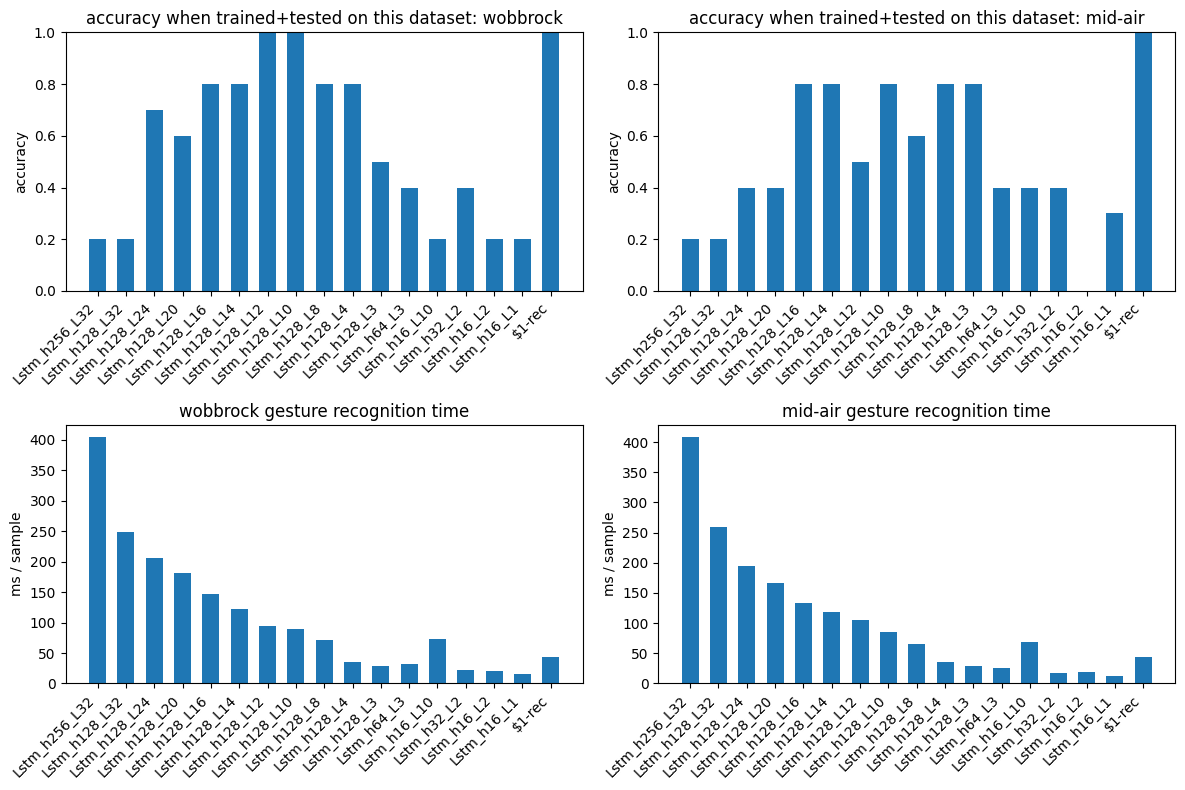

In [ ]:
fig, axes_grid = plt.subplots(2, 2, figsize = (12, 8))
axes_flattened = axes_grid.ravel()

for idx, current_split_name in enumerate(["wobbrock", "mid-air"]):
    subset_df  = dataframe_results[dataframe_results.evalset == current_split_name]
    ordered_df = subset_df.sort_values("params", ascending = False)
    model_order = ordered_df.model.values
    x_positions = np.arange(len(model_order))
    bar_width   = 0.6

    axes_flattened[idx].bar(x_positions,
                            ordered_df.set_index("model").loc[model_order].acc,
                            bar_width)
    axes_flattened[idx].set_xticks(x_positions)
    axes_flattened[idx].set_xticklabels(model_order, rotation = 45, ha = "right")
    axes_flattened[idx].set_ylim(0, 1)
    axes_flattened[idx].set_ylabel("accuracy")
    axes_flattened[idx].set_title(f"accuracy when trained+tested on this dataset: {current_split_name}")

    axes_flattened[idx + 2].bar(x_positions,
                                ordered_df.set_index("model").loc[model_order].ms,
                                bar_width)
    axes_flattened[idx + 2].set_xticks(x_positions)
    axes_flattened[idx + 2].set_xticklabels(model_order, rotation = 45, ha = "right")
    axes_flattened[idx + 2].set_ylabel("ms / sample")
    axes_flattened[idx + 2].set_title(f"{current_split_name} gesture recognition time")

plt.tight_layout()
plt.show()


In [ ]:
dataframe_results.sort_values(["evalset", "params"], ascending = [True, False])


,model,evalset,params,acc,ms
16,Lstm_h256_L32,mid-air,16551173,0.2,408.31156
17,Lstm_h128_L32,mid-air,4146821,0.2,259.03022
18,Lstm_h128_L24,mid-air,3094149,0.4,194.28948
19,Lstm_h128_L20,mid-air,2567813,0.4,166.26617
20,Lstm_h128_L16,mid-air,2041477,0.8,133.32693
21,Lstm_h128_L14,mid-air,1778309,0.8,119.04023
22,Lstm_h128_L12,mid-air,1515141,0.5,105.13091
23,Lstm_h128_L10,mid-air,1251973,0.8,84.92627
24,Lstm_h128_L8,mid-air,988805,0.6,66.18903
25,Lstm_h128_L4,mid-air,462469,0.8,35.74150


In [ ]:
import math

best_model_wobbrock = max(trained_models_for_wobbrock,
                          key = lambda m : evaluateSingleLstm(m, X_wob_test, y_wob_test)[0])
best_model_mid_air  = max(trained_models_for_mid_air ,
                          key = lambda m : evaluateSingleLstm(m, X_mid_test, y_mid_test)[0])

def confidenceIntervalForDifference(acc1, acc2, n_samples, z_val = 1.96):
    standard_error = math.sqrt(acc1*(1-acc1)/n_samples + acc2*(1-acc2)/n_samples)
    difference_val = acc1 - acc2
    lower_bound    = difference_val - z_val * standard_error
    upper_bound    = difference_val + z_val * standard_error
    return difference_val, lower_bound, upper_bound

def writecomparisonReport(label_string, lstm_model, X_feat, y_labels):
    accuracy_lstm, _ = evaluateSingleLstm(lstm_model, X_feat, y_labels)
    accuracy_one_dollar,_ = evaluateDollarRecognizer(X_feat, y_labels)

    diff, lo, hi = confidenceIntervalForDifference(accuracy_lstm, accuracy_one_dollar, len(y_labels))

    print(label_string)
    print("  LSTM   accuracy :", round(accuracy_lstm, 3))
    print("  $1-rec accuracy :", round(accuracy_one_dollar, 3))
    print("  Delta =", round(diff, 3), "  (95 % CI:", f"[{round(lo,3)}, {round(hi,3)}])")
    if lo>0:
        print("  -> LSTM clearly better\n")
    elif hi<0:
        print("  -> $1 clearly better\n")
    else:
        print("  -> No significant difference\n")

writecomparisonReport("Wobbrock (mouse)", best_model_wobbrock, X_wob_test, y_wob_test)
writecomparisonReport("Own Dataset (Mid-air)",             best_model_mid_air , X_mid_test, y_mid_test)


Touchpad / Wobbrock
  LSTM   accuracy : 1.0
  $1-rec accuracy : 1.0
  Delta = 0.0   (95 % CI: [0.0, 0.0])
  -> No significant difference

Mid-air
  LSTM   accuracy : 0.8
  $1-rec accuracy : 1.0
  Delta = -0.2   (95 % CI: [-0.448, 0.048])
  -> No significant difference



## FINDINGS

It is possible to train an LSTM to achieve 100% accuracy on Wobbrock dataset. In our case this took 128 Hidden Units and 10 Layers. However, it took 89.6ms vs the 1$ recognizer (that achieved 100% accuracy on both datasets) which took 42.6ms.

For the Mid-Air Dataset, the LSTM performed worse, only reaching 80% accuracy. A larger dataset might help, but it seems the jitteryness of mid-air data might negatively influence LSTM more than the 1$-recognizer.

Experiments with different parameter counts revealed that a large number of Hidden Units / Layers massively increases training time and milliseconds per gesture recognition. Too huge amounts of parameters also lead to terrible accuracy. Best results were achieved at "just" 1251973 parameters.

A significance test was performed, but due to the low number of samples in our dataset, results were below the significance level of 0.05.

In our case, the 1$ recognizer won out in both speed and accuracy. The C# Version of the 1$ recognizer would be even faster. That is hard to compete with, especially for small devices like smart watches!

The strength of the AI model might lie in its ability to generalize when given a larger dataset, or with recognizing more varied/less strictly drawn gestures.